# Correlation and Regression Maps: CMIP6
### Authors

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Packages](#path)

[Background: ENSO, Correlation and Regression Analysis](#info)

[Load and Query the CMIP6 Catalog](#load)

[Read in Data](#xarray)

[Calculate Regionally Averaged Time Series](#time_series)

[Calculate Correlation or Regression Coefficients](#corr)

[Make Maps](#maps)

<a id='purpose'></a> 
## **Goals**

In this tutorial, we will work with the CMIP6 catalog hosted on Amazon Web Services. The goal this time is to use correlation and/or regression analysis to identify the places where temperature is most highly correlated with temperature in a given location (in our case: the "NINO3.4" region in the central equatorial Pacific Ocean). This will be done by relating _gridpoint_ information from all locations to _time series_ information for a _regional average_ of sea surface temperature.

Skills provided in this tutorial:
- Mapping of geospatial data;
- Regional averaging;
- Working with multiple climate variables;
- Linear regression analysis;
- Correlation analysis (Pearson's R)
- Use of Python's `apply_ufunc` to apply calculations across multi-dimensional datasets

### **This is the Code-Along version of tutorial 1!!**

This notebook contains only a selected subset of the code for tutorial 1, so that it can be completed in a "code along" format in a classroom context. If you would like the fully completed version, please see "1. Correlation and Regression Maps.ipynb" in this repo.



<a id='path'></a> 
## **Import Packages**

As always, we begin by importing the necessary packages for our analysis. This tutorial assumes that you have all the packages needed for the [Plotting Regional Time Series](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/2.%20Plotting%20Regional%20Time%20Series%20Using%20Shapefiles.ipynb) tutorial in the EnsembleAnalysis repo installed; if you need more details on these packages, please see that tutorial.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats

<a id='info'></a> 
## **Background**

Let's start with a refresher (or introduction) to the basics of correlation and regression analysis, and a common way that this is used in climate research. I'm including both correlation and regression in this tutorial for two reasons:
1) They are both extremely commonly used across climate and environmental science; and
2) From a coding perspective, their implementation is ALMOST identical (we'll see more on that below).

### **Correlation: Pearson's R**

The _correlation coefficient_, sometimes called Pearson's R, is a number that quantifies the relationship between two variables. Its value can range from -1, where the quantities are perfectly but negatively related, to +1, where the relationship is perfect and positive. In Python, there are various packages which can compute this: here we'll use the `pearsonr` function that's part of the `scipy.stats` package. That's the same package we were using in previous tutorials to calculate kernel density estimates!

### **Linear Regression**

The _regression coefficient_ is different from the correlation: it represents the _slope_ of the linear fit between two variables. There are many resources available online describing the basic principles of linear regression; we like this one:
- [Linear Regression in Python](https://realpython.com/linear-regression-in-python/)

To perform our linear regressions today, we'll be using `scipy.stats` again, but this time a different function: it's now called `linregress`.

For both the correlation and linear regression options, the quantities we'll need are:
- the coefficient itself (either Pearson's R or regression slope), and
- the p-value associated with the correlation or linear fit.

These will be calculated not just once, but for **every single lat/lon point in your data**!

### **ENSO and the NINO3.4 Region**

We'll use a slightly different example in this tutorial: instead of looking just at atmospheric fields, we'll be performing a common analysis that's used in climate research. This is a correlation/regression with the _NINO3.4_ region: this is a pre-defined box in latitude and longitude that's considered to be an _"index region"_ for the El Nino/Southern Oscillation, or ENSO. 

#### **What is ENSO?**

If you haven't heard about it before, ENSO is a major _mode_ of climate variability that involves both the atmosphere and the ocean: they talk to each other, or are what we call "coupled" in climate research. ENSO has a _period_ that's irregular but is about 5-7 years, and alternates between two _phases_: El Nino and La Nina. During an El Nino event, the equatorial Pacific is _warmer_ than average, and during a La Nina, it's _colder_ than average. 

Here is a good explainer about what ENSO is from [NOAA's climate.gov blog](https://www.climate.gov/news-features/blogs/enso/what-el-ni%C3%B1o%E2%80%93southern-oscillation-enso-nutshell)!

**_Why do we care?_** The pattern of equatorial Pacific temperature is really important! It can cause changes to weather patterns all over the world, drive coral bleaching in the tropical oceans, and cause major economic damages. 

Getting back to the NINO3.4 region: this is an "index" for ENSO because it sits right in the middle of where El Nino and La Nina events have their peak heating or cooling. So if we take an average from a box in the middle, we have a good idea of what type of ENSO conditions we're currently experiencing. 

Here is what NINO3.4 looks like on a map (image source [NOAA](https://www.climate.gov/media/5541) again):

<a href="https://www.climate.gov/sites/default/files/Fig3_ENSOindices_SST_large.png">
  <img src="https://www.climate.gov/sites/default/files/Fig3_ENSOindices_SST_large.png" alt="image" width="400">
</a>

(note: there are also a bunch of OTHER index regions with different numbers, that are used for different aspects of ENSO science. We won't worry about all of them today, but it's good to know that they're out there!)

<a id='load'></a> 
## **Load and Query the CMIP6 Catalog**

Now we can use `intake` to load the information associated with the CMIP6 holdings on Amazon Web Services! More detail on that database is available on the [Amazon Registry of Open Data](https://registry.opendata.aws/cmip6/).


In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

We'll use the same techniques we learned when we were working on [ensemble analyses](https://github.com/climate-datalab/EnsembleAnalysis) with CMIP6: here let's just stick to a single model to make things simpler for now. (Many research projects do involve looking at correlations and regressions with multiple models though, so that's something that's good to be aware of!)

Start with specifying the search terms you want: as a starting example, we can just use the historical information from CESM2. 

_One thing that's different_ here from the previous work we were doing - although we're grabbing a single set of experiments, we'll want multiple _variables_! In this case, the ones we're interested in are:
- tos, the "temperature at the ocean surface" (this is how we'll calculate the NINO3.4 index); and
- pr, the precipitation field that we'll correlate/regress on NINO3.4.

Because tos is an ocean field and pr is an atmosphere field, I have include both "Amon" and "Omon" in the `table_id` part of the query. You need to include these because otherwise both daily and monthly information for tos and pr will be returned by the search!

In [3]:
# Specify search terms to query catalog 
# activity_id: which downscaling technique do you want?
activity_id = ["CMIP"]

# experiment_id: which historical/future scenario do you want?
experiment_id = ["historical"]

# table_id: which part of the Earth system/time resolution do you want?
table_id = ["Amon", "Omon"]

# source_id: which model do you want?
source_id = ["CESM2"]

# variable_id: which variable do you want?
variable_id = ["tos", "pr"]

Let's extract the catalog information for the above query, then take a look at the output.

In [4]:
# Search through catalog, store results
cesm_res = catalog.search(activity_id=activity_id, experiment_id=experiment_id,
                         source_id=source_id, table_id=table_id, variable_id=variable_id)

# Create a data frame
cesm_df = cesm_res.df

# Look at results
display(cesm_df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r3i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r3i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r5i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
3,CMIP,NCAR,CESM2,historical,r5i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
4,CMIP,NCAR,CESM2,historical,r2i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
5,CMIP,NCAR,CESM2,historical,r2i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
6,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
7,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
8,CMIP,NCAR,CESM2,historical,r6i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
9,CMIP,NCAR,CESM2,historical,r6i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308


There is a lot of information here! Let's explore it a little bit to make sure we understand what's going on. For instance: there are some entries for the `tos` data that look almost identical...

The below code block extracts just the portion of the `cesm_df` data frame containing tos data, then compares two entries to see what's actually different between them.

In [8]:
# Look just at the tos entries
cesm_tos = cesm_df[cesm_df['variable_id'] == 'tos']

display(cesm_tos[0:2])

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r3i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r3i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308


The two entries above differ only in their `grid_label`! (well also in the zstore entry, but that's to be expected since they're two different zarr stores). One grid_label entry is `gr` and one is `gn`: you may recall from the [Opening and Querying the CMIP6 Catalog](https://github.com/climate-datalab/CMIP6_AWS/blob/main/1.%20Opening%20and%20Querying%20the%20CMIP6%20Catalog.ipynb) tutorial that `gn` means "grid native", or data that has not been interpolated to a grid other than the one used when running the model. The other entry, `gr`, means "grid regular", or data that _has_ been put on a new grid after the model was run.

Let's confirm by displaying the data in more detail!

In [9]:
# Open first CESM tos dataset to look at it
test1 = xr.open_zarr(cesm_tos['zstore'][0], storage_options={'anon': True})
print(test1)

<xarray.Dataset>
Dimensions:    (lat: 180, d2: 2, lon: 360, time: 1980)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, d2) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, d2) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:59:59.999997 ... 2014-12-15 12:00:00
    time_bnds  (time, d2) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: d2
Data variables:
    tos        (time, lat, lon) float32 dask.array<chunksize=(385, 180, 360), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  240900.0
    case_id:                17
    ...                     ...
    variable_id:    

In [10]:
# Open second CESM tos dataset to look at it
test2 = xr.open_zarr(cesm_tos['zstore'][1], storage_options={'anon': True})
print(test2)

<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 320, vertices: 4, time: 1980, d2: 2)
Coordinates:
    lat        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * time       (time) object 1850-01-15 12:59:59.999997 ... 2014-12-15 12:00:00
    time_bnds  (time, d2) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: vertices, d2
Data variables:
    tos        (time, nlat, nlon) float32 dask.array<chunksize=(403, 384, 320), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF

Sure enough, in the first case (`grid_label = 'gr'`), the latitude and longitude are on a _regular grid_ spaced every 1 degree! The second one (`grid_label = 'gn'`) has much more irregularly spaced and numerous lat/lon values: and you may ALSO have noticed that this one is using _two-dimensional_ lat/lon values, whereas in the first example the lat/lon are 1D vectors.

The above was just to explore - but now that we have a better idea of what we're looking for, it's clear that the `gr` values are going to be easier to work with for these purposes. So let's stick with those, and redo our search query!

NOTE: if you read the code blocks above closely, you may have noticed that the PRECIPITATION values are on the native grid (`grid_label=gn`). So in order to extract just the tos data that's on the REGULAR grid (`grid_label=gr`), we'll have to separate our search queries this time. See below:

In [11]:
# Search through catalog, store results for tos
cesm_res_tos = catalog.search(activity_id=activity_id, experiment_id=experiment_id,
                         source_id=source_id, table_id=table_id, 
                         variable_id='tos', grid_label='gr')

# Recreate the data frame
cesm_tos_df = cesm_res_tos.df

# Display the data frame
display(cesm_tos_df)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r3i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r5i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r2i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
3,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
4,CMIP,NCAR,CESM2,historical,r6i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
5,CMIP,NCAR,CESM2,historical,r4i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
6,CMIP,NCAR,CESM2,historical,r7i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
7,CMIP,NCAR,CESM2,historical,r8i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
8,CMIP,NCAR,CESM2,historical,r9i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
9,CMIP,NCAR,CESM2,historical,r10i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190313


In [13]:
# Search through catalog, store results for precip
cesm_res_pr = catalog.search(activity_id=activity_id, experiment_id=experiment_id,
                         source_id=source_id, table_id=table_id, 
                         variable_id='pr')

# Recreate the data frame
cesm_pr_df = cesm_res_pr.df

# Display the data frame
display(cesm_pr_df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
1,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
2,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
3,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
4,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
5,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
6,CMIP,NCAR,CESM2,historical,r7i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
7,CMIP,NCAR,CESM2,historical,r6i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
8,CMIP,NCAR,CESM2,historical,r11i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190514
9,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20200124


OK now we're in business! There are the same number of entries for `tos` and `pr` now, so let's start getting the data I/O sorted out. 

Even though the ensemble member entries look identical in this case, let's still go through the exercise of finding the members that the two variables have in common - this will come in handy if you're working with a model where they did NOT provide data for every member for every variable (this happens surprisingly often in CMIP6 analyses). The code steps needed to do this are exactly the same as the ones we used previously, in the [Ensemble Spread and Statistical Significance](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/3.%20Ensemble%20Spread%20and%20Statistical%20Significance.ipynb) tutorial. The only difference is that now we're comparing the common members between two _variables_, not between two different _model experiments_.

In [14]:
# Define list of ensemble members
# tos
mems_tos = cesm_tos_df.member_id.unique()

# pr
mems_pr = cesm_pr_df.member_id.unique()

# Find the ones each list has in common
common_mems = list(set(mems_tos) & set(mems_pr))

# Print
print(common_mems)

['r3i1p1f1', 'r1i1p1f1', 'r6i1p1f1', 'r4i1p1f1', 'r7i1p1f1', 'r5i1p1f1', 'r11i1p1f1', 'r9i1p1f1', 'r10i1p1f1', 'r8i1p1f1', 'r2i1p1f1']


Now we can use our understanding of subsampling data frames based on the `member_id` field to loop through all of the members for which tos and pr data are available, find their location in the appropriate data frame, and add to an output list. 

For more details on this, you can refer back to the [Ensemble Spread and Statistical Significance](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/3.%20Ensemble%20Spread%20and%20Statistical%20Significance.ipynb) tutorial for a full explanation.

**Brief note:** in the loop below, I have added the `.load()` command to the data extraction step in `xr.open_zarr`, in order to force Python to load the data into memory before appending it to the output list. Not doing this resulted in an error in the _next_ code block (which involves concatenating data using `xr.concat`) related to Python not being able to _rechunk_ the data. Rechunking isn't really the point of this tutorial, but if you're curious about it you can check out the [explainer on parallel computing with Dask](https://docs.xarray.dev/en/stable/user-guide/dask.html) to see what's going on under the hood!

On the Bren School "workbench1" server, the code block below takes roughly 2-3 minutes to execute:

In [15]:
# Define empty lists for output data
cesm2_tempdata = []
cesm2_prdata = []

# Loop over all common ensemble members; grab both temperature
# and precip for each member
for mem in range(len(common_mems)):
    print(common_mems[mem])

    # Extract member of interest
    prec_cesm2df = cesm_pr_df[(cesm_pr_df["member_id"] == common_mems[mem])]
    tos_cesm2df = cesm_tos_df[(cesm_tos_df["member_id"] == common_mems[mem])]
    
    # Store data as xarray
    hist_pr = xr.open_zarr(prec_cesm2df['zstore'].iloc[0], storage_options={'anon': True}).load()
    hist_tos = xr.open_zarr(tos_cesm2df['zstore'].iloc[0], storage_options={'anon': True}).load()
    
    # Reassign time for all entries aside from the first one
    if mem == 0:
        common_time = hist_tos.time
    else:
        hist_tos['time'] = common_time    
        
    # Add to list
    cesm2_tempdata.append(hist_tos)
    cesm2_prdata.append(hist_pr)

r3i1p1f1
r1i1p1f1
r6i1p1f1
r4i1p1f1
r7i1p1f1
r5i1p1f1
r11i1p1f1
r9i1p1f1
r10i1p1f1
r8i1p1f1
r2i1p1f1


Now we follow our standard steps of concatenating the data into xarray objects - one for each variable - and adding the member names as values in the new "member" dimension!

In [16]:
# Concatenate the list into a single xarray object
cesm2_tempdata = xr.concat(cesm2_tempdata, dim="member")
cesm2_prdata = xr.concat(cesm2_prdata, dim="member")

# Store the actual member information as values of the new dimension
cesm2_tempdata = cesm2_tempdata.assign_coords(member=("member", common_mems))
cesm2_prdata = cesm2_prdata.assign_coords(member=("member", common_mems))

# Reformat time dimension for concatenated array
cesm2_tempdata['time'] = cesm2_tempdata.time.astype('datetime64[ns]')

<a id='time_series'></a> 
## **Calculate Regionally Averaged Time Series**

Here we need to step back a little and remember what our goal is. We're aiming to see how temperature in ONE place (the NINO3.4 index region) is related to precipitation in EVERY OTHER place (here, the rest of the world). That means we have one more thing to do before we can calculate the correlation/regression maps: namely, to actually make time series for our _target region_ of NINO3.4. Luckily, we already know how to do this from previous tutorials!

The code block below specifies a lat/lon region and performs the regional average from the `cesm2_tempdata` xarray variable we already defined. (note: here I'm not going to bother with area weighting because the region is fairly small and I want to make the code more readable)

In [17]:
# Specify rough lat/lon bounds for NINO3.4
lat_min, lat_max = -5, 5
lon_min, lon_max = 190, 240

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
mask_lat = (cesm2_tempdata.lat >= lat_min) & (cesm2_tempdata.lat <= lat_max)
mask_lon = (cesm2_tempdata.lon >= lon_min) & (cesm2_tempdata.lon <= lon_max)

# Find points where the mask value is True, drop all other points
cesm2_nino34 = cesm2_tempdata.where(mask_lat & mask_lon, drop=True)

# Average over the lat and lon dimensions
cesm2_nino34 = cesm2_nino34.mean(dim="lat").mean(dim="lon")

### **Calculate anomalies**

We also want to do one more thing to the time series: that is, to calculate the _anomaly_ by removing the _climatological average_ from the data. We'll do this using the xarray `groupby` command: if you'd like a reminder on how this all works, please refer to the [Anomalies](https://github.com/climate-datalab/Time-Series-Plots/blob/main/4.%20Anomalies.ipynb) tutorial.

In [18]:
# Calculate seasonal average
cesm2_nino34_clim = cesm2_nino34.groupby("time.month").mean("time")

# Print output to see what it looks like
print(cesm2_nino34_clim)

<xarray.Dataset>
Dimensions:  (month: 12, member: 11)
Coordinates:
  * member   (member) <U9 'r3i1p1f1' 'r1i1p1f1' ... 'r8i1p1f1' 'r2i1p1f1'
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tos      (month, member) float32 26.8 26.8 26.75 26.86 ... 26.6 26.7 26.67


In [19]:
# Remove seasonal mean to get the anomaly
cesm2_nino34_anom = cesm2_nino34.groupby("time.month") - cesm2_nino34_clim

Just as a quick sanity check, let's plot the NINO3.4 anomaly time series for the first ensemble member (`.isel(member = 0)`). This should give you numerical values that range between roughly -4 and +4:

Text(0, 0.5, 'NINO3.4 SST anomaly (C)')

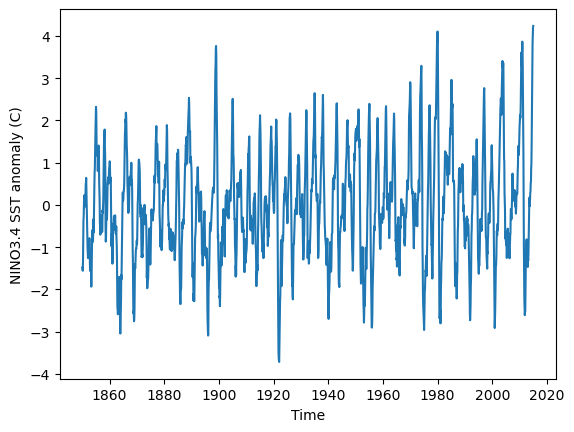

In [20]:
plt.plot(cesm2_nino34_anom.time, cesm2_nino34_anom.tos.isel(member=0))
plt.xlabel('Time')
plt.ylabel('NINO3.4 SST anomaly (C)')

<a id='corr'></a> 
## **Calculate Correlation or Regression Coefficients**

Now the fun part begins - we get to calculate our coefficient values! Let's define a "flag", or variable that keeps track of which type of coefficient we'd like to compute: this will let us quickly switch back and forth between regression and correlation if we change our minds about what we'd like to do later on. Here I've arbitrarily defined 0 to mean a correlation coefficient and 1 to mean a regression; you can change this to whatever you want! The only trick is to keep track of it later on when you're setting the relevant if statements (see below).

In [ ]:
# Type of coefficient
# 0 = correlation, 1 = regression
coef_type = 0

### **Handling multiple dimensions: `apply_ufunc`**

If we were working with data that was just a single time series, the next part would be simple: stick the data into either the `pearsonr` or `linregress` function, look at the results, and be done with it. But climate data is more complicated than that! Instead of one dimension, we have FOUR: time, latitude, longitude, and member. That means that we need a way to make Python loop over those dimensions and deal with them appropriately!

Luckily, within xarray there's a function that does exactly what we want: `apply_ufunc`. This applies a function defined by the user, across a _dimension_ within a dataset that's also defined by the user. In this case, what we want to do is:
- apply a CORRELATION or REGRESSION function
- across the dimension of TIME

Technically, this means that we need to define our own function, that essentially says "Hello, I am a function that applies [correlation/regression] to data you give me". Here's an example of how to do this:

In [26]:
# Define correlation and regression functions

# 1) correlation
# Input data: two time series called x and y
def corr_ts(x, y):
    # Get rid of any Nan/Inf values
    mask = np.isfinite(x) & np.isfinite(y)
    # Make sure there is still data
    if mask.sum() < 2:
        return np.nan, np.nan
    
    # Output data: R, p-value for x vs y
    r, p = stats.pearsonr(x[mask], y[mask])
    
    return float(r), float(p)

# 2) regression
# Input data: two time series called x and y
def reg_ts(x, y):
    # Get rid of any Nan/Inf values
    mask = np.isfinite(x) & np.isfinite(y)
    # Make sure there is still data
    if mask.sum() < 2:
        return np.nan, np.nan
    # Perform regression on good data, return slope and p-value
    regval = stats.linregress(x[mask], y[mask])
    
    return regval.slope, regval.pvalue

Now that we have both of our functions defined, we next have to apply them to our input data - then we'll have some nice maps to plot!

### **Note on correlation/regression and ensembles**

Here it's important to explain one concept that can be tricky when getting started. In our particular case we're only using ONE ensemble member. But you might have data from multiple members... and in that case, you need to be careful. 

_Rule of thumb: ALWAYS calculate correlations/regressions INDIVIDUALLY for EACH ensemble member!_

I've stated the above rule of thumb, because when you're doing a correlation or regression map, you're usually looking for a relationship between two variables **through time**. If you do something like average the ensemble members together _before_ doing the regression or correlation, you'll end up destroying the temporal relationship between your variables! That's because, as we've talked about in other tutorials, each ensemble member has a _different_ time history of climate variability: so on average, they'll end up canceling each other out!

_Other rule of thumb: It's totally fine to average correlation/regression maps AFTER you calculate them for each member!_

This may sound a little counter-intuitive, but it **is** ok to average your maps together after you make them separately for each member! That's because once you've identified the correlation/regression relationships _within_ ensemble members, they'll 

a) usually be pretty similar to each other, and
b) be _independent estimates_ of the temporal relationship between your two variables (since each ensemble member is independent of the others).

So it can actually make your statistics BETTER to average things together... as long as you do it AFTER the correlation/regression calculation!

### **Applying the correlation/regression function to data**

Let's now go ahead and actually do this thing. We'll need to loop over three of our four dimensions:
- ensemble member
- latitude
- longitude

and for each of those iterations, use `xr.apply_ufunc()` to apply our user-defined functions to the time series at that location/member.

#### Aligning time dimension

I'm going to add in one more step, since I was getting errors during the course of developing this tutorial. There are VERY SLIGHT (think one second) offsets between the time values in the tos and pr datasets - this led to an error that looked like this when I tried to run the code block below:
`ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',)`

To force this error to disappear, I'm just going to overwrite the `time` coordinate in the precipitation dataset with the one from the tos data - since we happen to know that these SHOULD be the same, this is a fine thing to do. However, _this type of thing needs to be done very carefully_ since you run the risk of using incorrect values if you're not careful! Always triple check before overwriting any data in arrays that you'll be using for your analysis!

In [27]:
# Force tos, pr time dimensions to match
cesm2_prdata['time'] = cesm2_nino34_anom.time

#### Setting up output arrays, formatting data

Now we need to define output arrays, where the results of the gridpoint correlations/regressions will be stored. This is done in Numpy in the code block below. I've also done a couple other tweaks to the data:
- used `.isel()` to select a SINGLE ensemble member (the code was running very slowly when considering all members); and
- used the Numpy `broadcast_to()` method to create duplicate copies of the NINO3.4 index time series at all lat and lon values in the output precipitation array. This is called broadcasting since you're "sending" the same values to all locations, and will trick the xarray `apply_ufunc()` method into behaving correctly later.

If you do want to perform your analysis on all ensemble members, you can just delete the `.isel()` part of the code below - note that this will result in your outputs having an additional dimension, namely "member". You'll then need to average across that dimension before plotting!

In [28]:
# Select data from a single ensemble member to make things run faster
this_nino34 = cesm2_nino34_anom.isel(member=0).tos
this_pr = cesm2_prdata.isel(member=0).pr

# broadcast NINO3.4 across lat/lon dimension
this_nino34_broadcasted = xr.DataArray(
    np.broadcast_to(
    this_nino34.values[:, np.newaxis, np.newaxis],
    this_pr.shape
    ),
    dims = ["time", "lat", "lon"],
    coords = {"time": this_nino34.time, "lat": this_pr.lat, "lon": this_pr.lon}
)



Now we perform the correlation! 

In [29]:
# Use apply_ufunc to do the looping over lat/lon, for a single member
coef_vals, p_vals = xr.apply_ufunc(
    corr_ts, this_nino34_broadcasted, this_pr,
    input_core_dims=[["time"], ["time"]],
    output_core_dims=[[], []],
    vectorize=True, dask = "parallelized", 
    dask_gufunc_kwargs={"allow_rechunk": True},
    output_dtypes=[float, float]
)

<a id='maps'></a> 
## **Make Maps**

Now that we've done all the hard parts, it's time to finally plot the results! We'll just use the output from the previous code blocks and lay them onto our map, similar to what was done in previous tutorials in this repo.

As a nice bonus, we'll ALSO add code to stipple (plot dots where) the locations where the significance levels are above 90%!

The below code block plots results for the correlation coefficient option - if you'd like to use the regression coefficients, just change the appropriate plot labels to match.

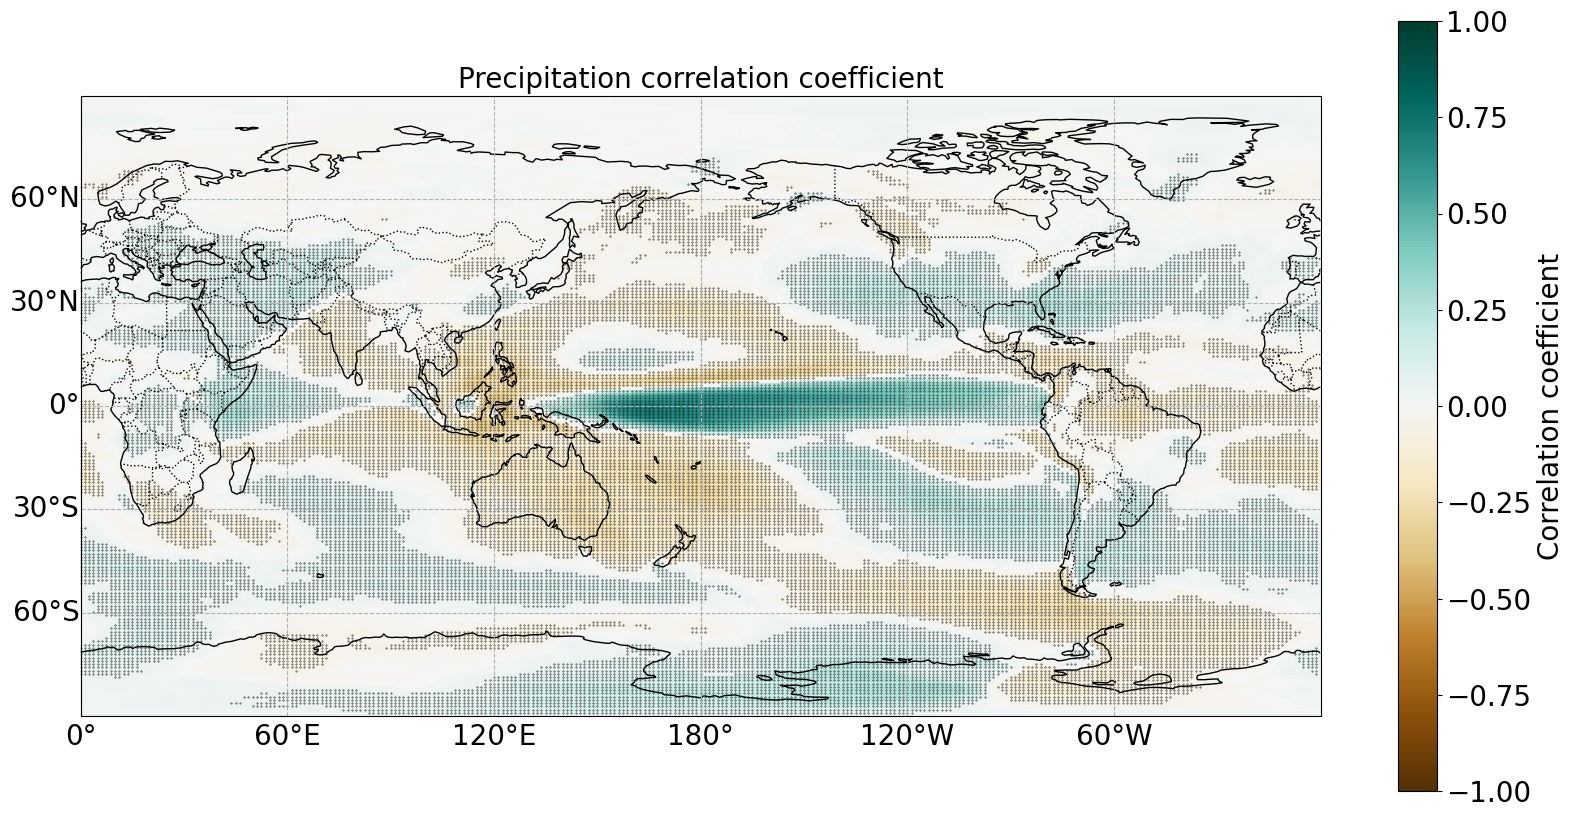

In [31]:
# Plot the results!
map = ccrs.PlateCarree(central_longitude=180)

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
# Plot data onto those axes
plot = ax.pcolormesh(this_pr.lon, this_pr.lat, coef_vals.squeeze(), 
                     transform=ccrs.PlateCarree(), cmap="BrBG", vmin=-1, vmax=1, shading='auto')# 
# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Correlation coefficient", fontsize=20)
cbar.ax.tick_params(labelsize=20)
# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Statistical significance for historical vs future precip change regressed on gradient change
latitudes, longitudes = np.where(p_vals.squeeze() < 0.05)
lats = this_pr.coords['lat'][latitudes].values
lons = this_pr.coords['lon'][longitudes].values
ax.scatter(lons, lats, color='black', s=0.1, transform=ccrs.PlateCarree())

# Add title, show plot
ax.set_title("Precipitation correlation coefficient", fontsize= 20)
plt.show()